In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# geopandas is used for texas state map... can be ignored if a different projection (i.e. cartopy) is used
# !pip3 install geopandas
# import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

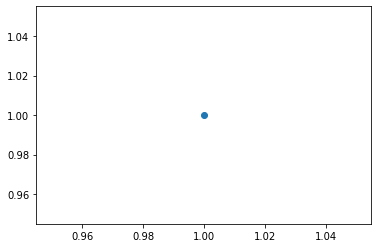

In [33]:
plt.plot(1,1,'o')

In [34]:
# TODO: implement randomization of parameters
K = 1.14
Beta = 10
r_mw = 30
r_s = 400
w_m = 75
psi = (1/r_mw)*math.log(K/(K-1))
E = K*w_m

# distance formula function
def distance(c_xval, c_yval, x_xval, x_yval):
  L = math.sqrt((c_xval-x_xval)**2 + (c_yval-x_yval)**2)
  return L;

# gradient wind field
def w(dist, r_mw, r_s, w_m):
  if dist>= 0 and dist<30:
    ans = (E)*(1-math.exp(-psi*dist))
  elif dist>=r_mw and dist<=r_s:
    ans = w_m*math.exp(-(np.log(Beta)/(r_s-r_mw))*(dist-r_mw))
  else:
    ans = 0
  return ans;

# takes in coordinates for hurricane eye, transmission pole 'A' and 'B' in a list/array of the form (x,y)
# returns minimum distance, maximum distance
def dminmax(eye, A, B):
  a, b, c = distance(eye[0], eye[1], B[0], B[1]), distance(A[0], A[1], eye[0], eye[1]), distance(A[0], A[1], B[0], B[1])
  s = (a+b+c)/2.0
  Area = math.sqrt(s*(s-a)*(s-b)*(s-c))
  d_min = (2*Area)/c
  if a>=b:
    d_max = a
  else:
    d_max = b
  return d_min, d_max

In [35]:
# implements Hurricane Impact Matrix using coordinates for dminmax() function...
# and variables to generate gradient wind field function passed in the form m_h = [r_mw, r_s, w_m]
# i.e. each hurricane j is defined in the HIM by its m_h values
def HIM(eye, transpostA, transpostB, m_h):
  r_mw, r_s, w_m = m_h[:]
  d_min, d_max = dminmax(eye, transpostA, transpostB)
  if d_min<=r_mw<=d_max:
    windspeed = w_m
  else:
    windspeed = max(w(d_min, r_mw, r_s, w_m), w(d_max, r_mw, r_s, w_m))
  return windspeed

In [36]:
# linedata_url = 'https://raw.githubusercontent.com/diegogc506/SummerInternship2021WSU/fb36aed54e6ba703e83c6ed08f4db041dfa5ff40/Texas2000busdata-LINES.txt'
# busdata_url = 'https://raw.githubusercontent.com/diegogc506/SummerInternship2021WSU/fb36aed54e6ba703e83c6ed08f4db041dfa5ff40/Texas2000busdata-BUS.txt'


# read in data and reduce columns
busdata_raw = pd.read_csv('Diego/Data/Texas2000busdata-BUS.txt', sep='\s+' )
busdata = busdata_raw[['BusNum', 'BusName', 'Latitude:1', 'Longitude:1']]
busdata['voltage'] = busdata_raw.drop_duplicates()['BusNomVolt']
busdata = busdata.set_index('BusNum')
busdata = busdata.append(pd.Series(name=np.NaN))

linedata_raw = pd.read_csv('Diego/Data/Texas2000busdata-LINES.txt', sep='\s+' )
linedata = linedata_raw[['BusNum','BusNum:1']]
linedata = linedata.drop_duplicates().reset_index().drop('index', axis=1 )
linedata['NaN'] = np.NaN

# 'pairs' organizes transmission lines into stacked DataFrame in the form:
# FROM BusNum
# TO BusNum:1
# NaN (to separate each pair)
pairs = linedata.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

longitudes = busdata['Longitude:1'][pairs[0][:]]
latitudes = busdata['Latitude:1'][pairs[0][:]]

# linedata['LineID']= linedata['BusNum'].astype(str) + '-' + linedata['BusNum:1'].astype(str)
# linedata.set_index('LineID')

linedata ['from(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum']],busdata['Latitude:1'][linedata['BusNum']]))
linedata ['to(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum:1']],busdata['Latitude:1'][linedata['BusNum:1']]))

/var/folders/sx/n2mn4km52tnc1chfnrcxvmpw0000gn/T/ipykernel_12558/3250914674.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  busdata['voltage'] = busdata_raw.drop_duplicates()['BusNomVolt']
/var/folders/sx/n2mn4km52tnc1chfnrcxvmpw0000gn/T/ipykernel_12558/3250914674.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  busdata = busdata.append(pd.Series(name=np.NaN))


In [37]:
# assumes hurricane for plotting purposes:
m_h = [r_mw, r_s, w_m]
eye = [28.9, 95.2]

linedata['MaxWindspeed'] = linedata.apply(lambda row : HIM(eye, row['from(X,Y)'], row['to(X,Y)'], m_h), axis = 1)

# linedata.sort_values('MaxWindspeed', ascending=False).to_csv('/content/linedata.csv')


In [38]:
10+10


20

In [39]:
# gets Texas map
usa = gpd.read_file('/content/drive/MyDrive/WSU Internship/States 21basic')

NameError: name 'gpd' is not defined

Text(0.5, 1.0, 'Texas Electrical Grid')

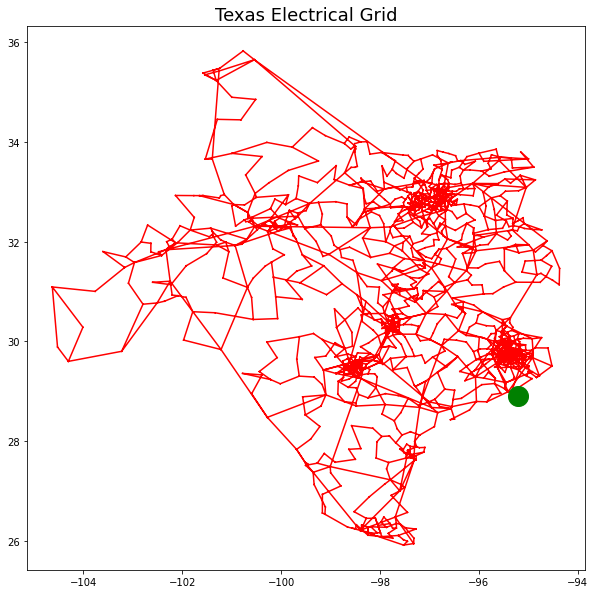

In [ ]:
# plots electrical grid in red with theoretical hurricane landfall
# usa[usa.state_name =='Texas'].plot(figsize=(10,10), alpha=0.5, edgecolor='k')
plt.plot(longitudes, latitudes, color='Red')
plt.plot(-95.2, 28.9, 'o', markersize=20, color='Green') #plots landfall as green dot#
fig = plt.gcf()
fig.set_size_inches(10, 10)
title = "Texas Electrical Grid"
plt.title(title, fontsize=18)

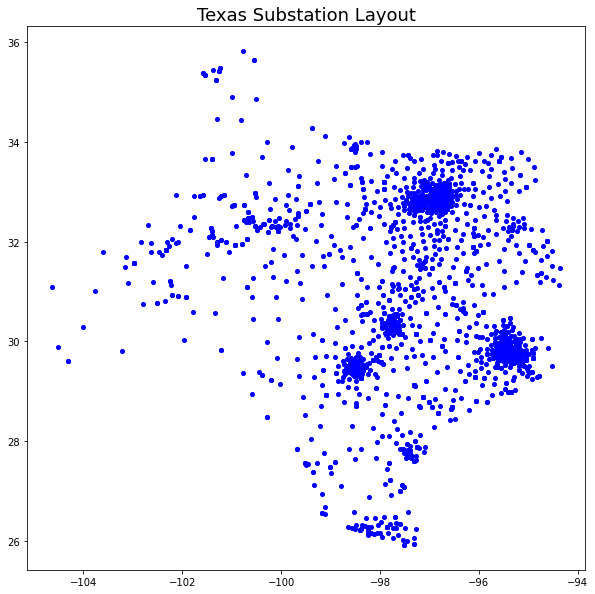

In [ ]:
x, y = busdata['Longitude:1'], busdata['Latitude:1'] 
# usa[usa.state_name =='Texas'].plot(figsize=(10,10), alpha=0.5, edgecolor='k')
plt.plot(x,y,'o', markersize = 4, color='Blue')
fig = plt.gcf()
fig.set_size_inches(10, 10)
title = "Texas Substation Layout"
plt.title(title, fontsize=18)
plt.show()

In [42]:
# adds voltage to linedata
busdata[:]['voltage']
volts = []
for i in linedata['BusNum']:
  volts.append(busdata['voltage'][i])
linedata['voltage'] = volts

# test
linedatatest = linedata[['BusNum','voltage']].copy().drop_duplicates()
linedatatest = linedatatest.set_index('BusNum')
for i in linedata ['BusNum']:
  if linedatatest['voltage'][i] != busdata['voltage'][i]:
    print('voltage ERROR', i)
  

In [43]:
# creates dataframes for each voltage level in grid
voltageI = linedata['voltage']
voltageI=[np.int16(x) for x in voltageI]
linedata['voltage']=voltageI

linedata_ByVoltage = [1,2,3,4]

voltageLevels = linedata['voltage'].unique()
for i in range(len(voltageLevels)):
  df = linedata[linedata['voltage']==voltageLevels[i]]
  linedata_ByVoltage[i] = df.filter(items=['BusNum', 'BusNum:1', 'NaN'])
linedata_115v = linedata_ByVoltage[0]
linedata_230v = linedata_ByVoltage[1]
linedata_500v = linedata_ByVoltage[2]
linedata_161v = linedata_ByVoltage[3]

pairs115 = linedata_115v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs230 = linedata_230v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs500 = linedata_500v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs161 = linedata_161v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

figlist = [pairs115, pairs230, pairs500, pairs161]
colors = ['Blue', 'Red', 'Purple', 'Green']



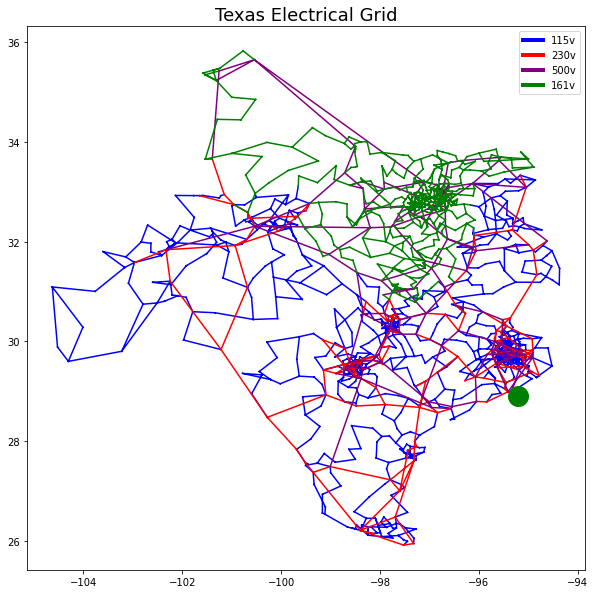

In [44]:
# plots grid colorcoded to voltage level
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]

# usa[usa.state_name =='Texas'].plot(figsize=(10,10), alpha=0.5, edgecolor='k')
fig = plt.gcf()
fig.set_size_inches(10, 10)
for count, i in enumerate(figlist):
  plt.plot(busdata['Longitude:1'][i[0][:]], busdata['Latitude:1'][i[0][:]], color=colors[count])
plt.plot(-95.2, 28.9, 'o', markersize=20, color='Green')
title = "Texas Electrical Grid"
plt.title(title, fontsize=18)
plt.legend(custom_lines, ['115v', '230v', '500v', '161v'])

In [71]:
df = pd.DataFrame()
lf = pd.DataFrame([1,2,3],[1,2,3])
arrayofarr = [np.array(range(10)),list(range(5)),list(range(4))]
df['arrs'] = arrayofarr
df
for index in df.index:
    print(index)
    df['arrs'][0] = np.append(df['arrs'][index], 123)
df['arrs'][0] = np.append(df['arrs'][0], 43)
df

0
1
2


,arrs
0,"[0, 1, 2, 3, 123, 43]"
1,"[0, 1, 2, 3, 4]"
2,"[0, 1, 2, 3]"
